<a href="https://colab.research.google.com/github/tushitgarg/Hate-Speech-Content-Moderation/blob/master/Co_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Libraries

In [108]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import pymongo
from pymongo import MongoClient
import pprint as pp
! pip install normalise
import nltk
nltk.download('names')
nltk.download('brown')

import numpy as np
import multiprocessing as mp

import string
import spacy 
import en_core_web_sm
from nltk.tokenize import word_tokenize
from sklearn.base import TransformerMixin, BaseEstimator
from normalise import normalise
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,GRU, SimpleRNN
from keras.layers.embeddings import Embedding
from keras import layers
from keras.initializers import Constant

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


# Text Preprocessing Pipeline

In [0]:
nlp = en_core_web_sm.load()


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()
        return X_copy.apply(self._preprocess_text)

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        text=self._clean_text(text)
        normalized_text = self._normalize(text)
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])
    
    
    def _clean_text(self,text):
      replace_1 = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
      replace_2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
      try:
        text=re.sub(r"http\S+", "", text)
      except:
        print(text)
      text = replace_1.sub("", text)
      text = replace_2.sub(" ", text)
      text=re.sub('\s+',' ',text)
      return text

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
cd '/content/drive/My Drive/minor2/Hate-Speech-Content-Moderation/'

/content/drive/My Drive/minor2/Hate-Speech-Content-Moderation


# Extracting text and labels

In [0]:
twitter_text=twitter['text']
twitter_labels=twitter['label']

In [0]:
quora_text=quora['text']
quora_labels = quora['label']

In [0]:
wiki_text=wiki['text']
wiki_labels=wiki['label']

# Splitting the text 

In [0]:
twitter_text2=[]
for i in twitter_text:
      lst=i.split()
      twitter_text2.append(lst)

In [0]:
quora_text2=[]
for i in quora_text:
      lst=i.split()
      quora_text2.append(lst)

In [0]:
wiki_text2=[]
for i in wiki_text:
      lst=i.split()
      wiki_text2.append(lst)

# Tokenizing and padding the texts

In [0]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(twitter_text2) 
tus = ["excited"]
sequences = tokenizer.texts_to_sequences(tus)
word_index = tokenizer.word_index
print('Found %s unique tokens.',len(word_index))
#twitter_maxlen = max([len(s.split()) for s in ' '.join(tus)])
tweets_pad = pad_sequences(sequences, maxlen=1)
print(tweets_pad.shape) 


Found %s unique tokens. 14884
(1, 1)


In [0]:
word_index['excited']

944

In [0]:
print(tus[0])
print(tweets_pad[0])

excited
[944]


In [0]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(quora_text2) 
sequences = tokenizer.texts_to_sequences(quora_text2)
word_index = tokenizer.word_index
print('Found %s unique tokens.',len(word_index))
quora_maxlen = max([len(s.split()) for s in quora_text])
quora_pad = pad_sequences(sequences, maxlen=quora_maxlen)
print(quora_pad.shape) 


Found %s unique tokens. 15507
(13842, 51)


In [0]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(wiki_text2) 
sequences = tokenizer.texts_to_sequences(wiki_text2)
word_index = tokenizer.word_index
print('Found %s unique tokens.',len(word_index))
wiki_maxlen = max([len(s.split()) for s in wiki_text])
wiki_pad = pad_sequences(sequences, maxlen=wiki_maxlen)
print(wiki_pad.shape) 

Found %s unique tokens. 32848
(10204, 1250)


# Making dataframes

In [0]:
twitter_df=pd.concat([pd.DataFrame(twitter_text),pd.DataFrame(tweets_pad)],axis=1)

In [0]:
quora_df=pd.concat([pd.DataFrame(quora_text),pd.DataFrame(quora_pad)],axis=1)

In [0]:
wiki_df=pd.concat([pd.DataFrame(wiki_text),pd.DataFrame(wiki_pad)],axis=1)

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history,name_of_fig):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    f=plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    f.savefig(name_of_fig, bbox_inches='tight', dpi=400)

# Co training Iterations

In [0]:
quora=pd.read_excel('quora.xlsx')

In [0]:
twitter = pd.read_excel('twitter2_data.xlsx')
twitter.drop(['level_0','index','Unnamed: 0'],axis=1,inplace=True)

In [0]:
wiki=pd.read_excel('wiki.xlsx')

In [116]:
print('Twitter:',twitter.shape)
print('Wiki:',wiki.shape)
print('Quora:',quora.shape)

Twitter: (10841, 3)
Wiki: (10204, 3)
Quora: (13842, 3)


In [117]:
np.mean(twitter['label'])
np.mean(wiki['label'])
np.mean(quora['label'])

0.29186533737899145

In [0]:
quora.columns = twitter.columns
wiki.columns = twitter.columns

In [119]:
%%time
twitter_text = TextPreprocessor(n_jobs=-1).transform(twitter['text'])

CPU times: user 2min, sys: 806 ms, total: 2min 1s
Wall time: 2min 1s


In [120]:
%%time
quora_text = TextPreprocessor(n_jobs=-1).transform(quora['text'])

CPU times: user 2min 27s, sys: 587 ms, total: 2min 27s
Wall time: 2min 28s


In [121]:
%%time
wiki_text = TextPreprocessor(n_jobs=-1).transform(wiki['text'])

CPU times: user 3min 7s, sys: 977 ms, total: 3min 8s
Wall time: 3min 8s


In [0]:
twitter['clean_text'] = twitter_text
wiki['clean_text'] = wiki_text
quora['clean_text'] = quora_text

In [0]:
def LoadGlove():
  print('Loading word vectors....')
  embeddings_index = {}
  f = open('/content/drive/My Drive/minor2/twitter2/glove.6B.100d.txt','r')
  for line in f:
      values = line.split()
      word = values[0]
      values = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = values
  f.close()
  print('Found %s word vectors.' % len(embeddings_index))
  return embeddings_index

In [0]:
def make_embedding_matrix(tokenizer,emb_mean,emb_std,embeddings_index):
  print('make_embedding_matrix function......')
  embedding_dim = 100
  word_index = tokenizer.word_index
  num_words = len(word_index)+1
  embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None: 
          embedding_matrix[i] = embedding_vector
  print("emb matrix shape:",embedding_matrix.shape)
  return embedding_matrix

In [0]:
def emb_mean_std(embeddings_index):
  all_embs = np.stack(embeddings_index.values())
  emb_mean = all_embs.mean() # Calculate mean
  emb_std = all_embs.std() # Calculate standard deviation
  return emb_mean,emb_std

In [0]:
def split_fun(text):
  print("splitting text into list....")
  text2=[]
  for i in text:
        lst=i.split()
        text2.append(lst)
  return text2

In [0]:
def make_lstm_model(word_index,embedding_matrix,maxlength):
  model = Sequential()
  embedding_layer = Embedding(len(word_index)+1,
                              100,
                              embeddings_initializer = Constant(embedding_matrix),
                              input_length = maxlength,
                              trainable=False)
  model.add(embedding_layer)
  model.add(LSTM(units=100))
  model.add(Dropout(.3))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  #model.summary()
  return model

In [0]:
def predict_data(model,Test_df):
  print("Predicting.......")
  #print(Test_df.shape)
  y_classes=model.predict_classes(Test_df.iloc[:,1:])
  #y_test = y_test.astype(int)
  return y_classes

In [0]:
def print_scores(y_test, y_classes):
  scores = []
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_test, y_classes)
  print('Accuracy:{}\n'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(y_test, y_classes)
  print('Precision:{}\n'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(y_test, y_classes)
  print('Recall:{}\n'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_test, y_classes)
  print('F1 score:{}\n'.format(f1))
  matrix = confusion_matrix(y_test, y_classes)
  print("Confusion Matrix:")
  print(matrix)
  scores.append(accuracy)
  scores.append(precision)
  scores.append(recall)
  scores.append(f1)
  return scores

  

In [0]:
def CoTrain(Train,Test,embeddings_index,mean,std):
  emb_mean,emb_std = mean,std

  train_text = Train['clean_text'].values
  train_labels = Train['label'].values
  test_text = Test['clean_text'].values
  test_labels = Test['label'].values

  #print('len of test_text:',len(test_text))

  train_text2 = split_fun(train_text)
  test_text2 = split_fun(test_text)

  #print('len of test_text2:',len(test_text2))

  tokenizer = Tokenizer() 
  tokenizer.fit_on_texts(train_text2)

  train_sequences = tokenizer.texts_to_sequences(train_text2)
  test_sequences =  tokenizer.texts_to_sequences(test_text2)

  #print('len of test_sequences:',len(test_sequences))

  word_index = tokenizer.word_index
  #print('Found %s unique tokens.',len(word_index))
  maxlength = 100
  #maxlength = max([len(s.split()) for s in train_text+test_text])
  
  train_pad = pad_sequences(train_sequences, maxlen=maxlength)
  test_pad =  pad_sequences(test_sequences, maxlen=maxlength)

  #print('len of test_pad:',len(test_pad))

  #print(test_pad[29])

  Train_df = pd.concat([pd.DataFrame(train_text),pd.DataFrame(train_pad)],axis=1)
  #print(pd.DataFrame(test_text))
  Test_df =  pd.concat([pd.DataFrame(test_text),pd.DataFrame(test_pad)],axis=1) 

  #print(Train_df.shape)
  #print(Test_df.shape)
  embedding_matrix = make_embedding_matrix(tokenizer,emb_mean,emb_std,embeddings_index)

  lstm_model = make_lstm_model(word_index,embedding_matrix,maxlength)

  print("Train Test Split data.......")
  from sklearn.model_selection import train_test_split
  X_train, X_val ,y_train, y_val = train_test_split(Train_df, train_labels, test_size = 0.30, random_state = 1)
  
  
  print('Training.....')
  history=lstm_model.fit(X_train.iloc[:,1:], y_train, batch_size=256,epochs=5,validation_data=(X_val.iloc[:,1:],y_val),verbose=False)
  
  predicted_classes = predict_data(lstm_model,Test_df)
  return print_scores(test_labels,predicted_classes)


In [186]:
embeddings_index = LoadGlove()
emb_mean,emb_std = emb_mean_std(embeddings_index)

Loading word vectors....
Found 400001 word vectors.


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [244]:
from sklearn.utils import shuffle
#embeddings_index = LoadGlove()
#emb_mean,emb_std = emb_mean_std(embeddings_index)
x = twitter
yl = wiki.sample(frac=0.3)
yu = wiki.drop(list(yl.index))
K = 5
r = len(yl)//5
scores = []
for k in range(K+1):
  #print(x.shape)
  score = CoTrain(x,yu,embeddings_index,emb_mean,emb_std)
  print(score)
  scores.append(score)
  z = yl.iloc[:r,:]
  yl = yl.drop(list(z.index))
  x =  pd.concat([x,z],axis=0)
  shuffle(x)
  x.reset_index(inplace=True, drop=True)

splitting text into list....
splitting text into list....
make_embedding_matrix function......
emb matrix shape: (14885, 100)
Train Test Split data.......
Training.....
Predicting.......
Accuracy:0.7169256614867703

Precision:0.636604774535809

Recall:0.11294117647058824

F1 score:0.19184652278177458

Confusion Matrix:
[[4881  137]
 [1885  240]]
[0.7169256614867703, 0.636604774535809, 0.11294117647058824, 0.19184652278177458]
splitting text into list....
splitting text into list....
make_embedding_matrix function......
emb matrix shape: (17552, 100)
Train Test Split data.......
Training.....
Predicting.......
Accuracy:0.7362452750944981

Precision:0.877742946708464

Recall:0.13176470588235295

F1 score:0.22913256955810152

Confusion Matrix:
[[4979   39]
 [1845  280]]
[0.7362452750944981, 0.877742946708464, 0.13176470588235295, 0.22913256955810152]
splitting text into list....
splitting text into list....
make_embedding_matrix function......
emb matrix shape: (19571, 100)
Train Test Spl

In [245]:
print("Average Accuracy:",sum([i[0] for i in scores[2:]])/4)
print("Average Precision:",sum([i[1] for i in scores[2:]])/4)
print("Average Recall:",sum([i[2] for i in scores[2:]])/4)
print("Average F1:",sum([i[3] for i in scores][2:])/4)

Average Accuracy: 0.7731345373092539
Average Precision: 0.8802402232088903
Average Recall: 0.2768235294117647
Average F1: 0.4155200040750405


In [0]:
ac = [i[0] for i in scores[1:]]

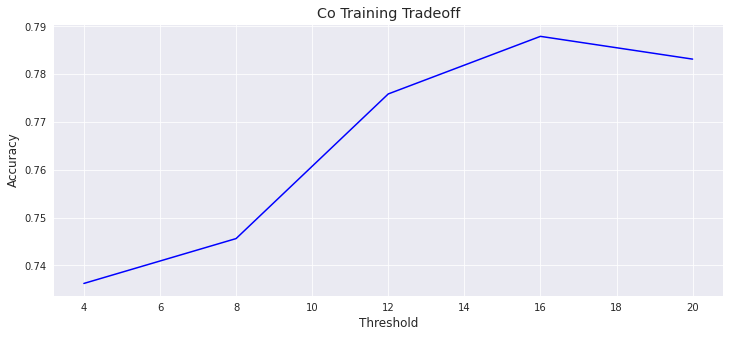

In [247]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

f=plt.figure(figsize=(12, 5))
sns.set_style("darkgrid")
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
#plt.xticks()
plt.title("Co Training Tradeoff")
plt.plot([4,8,12,16,20],ac, 'b',label='Quora')
plt.show()
#plt.legend()
f.savefig('/content/drive/My Drive/minor2/Hate-Speech-Content-Moderation/Co Training Tradeoff.jpg', bbox_inches='tight', dpi=400)

In [0]:
'/content/drive/My Drive/minor2/Hate-Speech-Content-Moderation/'

In [0]:
Average Accuracy: 0.7955345855156222
Average Precision: 0.799912665279091
Average Recall: 0.39837905236907734
Average F1: 0.5213841599405524